In [1]:
import scanpy as sc
import anndata as ann
import scipy as sci
import pandas as pd
import os
import numpy as np
import louvain

/home/97212545/anaconda3/envs/scanpygpu/lib/python3.6/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
%config InlineBackend.figure_format='retina'

# Loading the Data

In [3]:
SCRNA_DIR = '../data/scRNA/'

In [4]:
%%time
scrna = sc.read_10x_mtx(SCRNA_DIR, var_names='gene_ids', cache=True)

var = pd.read_csv(SCRNA_DIR + 'var.csv')
var.index = var.gene_name
scrna.var = var

obs = pd.read_csv(SCRNA_DIR + 'obs.csv')
obs.index = obs.iloc[:,0]
scrna.obs = obs

CPU times: user 3.29 s, sys: 19.9 s, total: 23.2 s
Wall time: 23.2 s


In [5]:
scrna

AnnData object with n_obs × n_vars = 53638 × 20287 
    obs: 'Unnamed: 0', 'Group', 'nUMI_pre', 'nUMI', 'nGene', 'ProjectUMAP1', 'ProjectUMAP2', 'ProjectClassification', 'Barcode'
    var: 'gene_name', 'gene_id', 'exonLength'

In [6]:
scrna.obs.head()

,Unnamed: 0,Group,nUMI_pre,nUMI,nGene,ProjectUMAP1,ProjectUMAP2,ProjectClassification,Barcode
Unnamed: 0,,,,,,,,,
RM2:AAACCTGAGTGTCCCG-1,RM2:AAACCTGAGTGTCCCG-1,MPAL5R_T1,1802,1441,896,-6.581877,3.819128,Progenitor_Like,AAACCTGAGTGTCCCG-1
RM2:AAAGATGGTCCGAGTC-1,RM2:AAAGATGGTCCGAGTC-1,MPAL5R_T1,12368,7988,3029,-6.184691,2.277092,Myeloid_Like,AAAGATGGTCCGAGTC-1
RM2:AAATGCCCAAATTGCC-1,RM2:AAATGCCCAAATTGCC-1,MPAL5R_T1,1945,1036,600,-5.550443,2.505810,Myeloid_Like,AAATGCCCAAATTGCC-1
RM2:AAATGCCTCGTTACAG-1,RM2:AAATGCCTCGTTACAG-1,MPAL5R_T1,2529,1551,957,-5.936206,2.888241,Progenitor_Like,AAATGCCTCGTTACAG-1
RM2:AACACGTAGGAGCGAG-1,RM2:AACACGTAGGAGCGAG-1,MPAL5R_T1,5864,3774,1592,-6.512098,-0.113418,Myeloid_Like,AACACGTAGGAGCGAG-1


# Data Cleaning

In [7]:
scrna.obs.drop('Unnamed: 0', axis=1, inplace=True)

In [8]:
scrna.obs.rename(columns={'ProjectClassification': 'cell_type'}, inplace=True)

In [9]:
scrna.obsm['X_umap'] = scrna.obs[['ProjectUMAP1', 'ProjectUMAP2']].to_numpy()
scrna.obs.drop(['ProjectUMAP1', 'ProjectUMAP2'], axis=1, inplace=True)

In [16]:
scrna.obs['condition'] = scrna.obs['cell_type'].map(lambda a: 'stimulated' if a.endswith('Like') else 'control')

In [17]:
scrna.obs

,Group,nUMI_pre,nUMI,nGene,cell_type,Barcode,condition
Unnamed: 0,,,,,,,
RM2:AAACCTGAGTGTCCCG-1,MPAL5R_T1,1802,1441,896,Progenitor_Like,AAACCTGAGTGTCCCG-1,stimulated
RM2:AAAGATGGTCCGAGTC-1,MPAL5R_T1,12368,7988,3029,Myeloid_Like,AAAGATGGTCCGAGTC-1,stimulated
RM2:AAATGCCCAAATTGCC-1,MPAL5R_T1,1945,1036,600,Myeloid_Like,AAATGCCCAAATTGCC-1,stimulated
RM2:AAATGCCTCGTTACAG-1,MPAL5R_T1,2529,1551,957,Progenitor_Like,AAATGCCTCGTTACAG-1,stimulated
RM2:AACACGTAGGAGCGAG-1,MPAL5R_T1,5864,3774,1592,Myeloid_Like,AACACGTAGGAGCGAG-1,stimulated
...,...,...,...,...,...,...,...
BMMC_10x_GREENLEAF_REP2:TTTGTTGAGTTAGTAG-1,BMMC_D1T2,7515,5240,2377,07_GMP,TTTGTTGAGTTAGTAG-1,control
BMMC_10x_GREENLEAF_REP2:TTTGTTGAGTTCATGC-1,BMMC_D1T2,1597,1338,882,12_CD14.Mono.2,TTTGTTGAGTTCATGC-1,control
BMMC_10x_GREENLEAF_REP2:TTTGTTGCAGTGGTGA-1,BMMC_D1T2,2831,1660,1004,19_CD8.N,TTTGTTGCAGTGGTGA-1,control


# Visualization

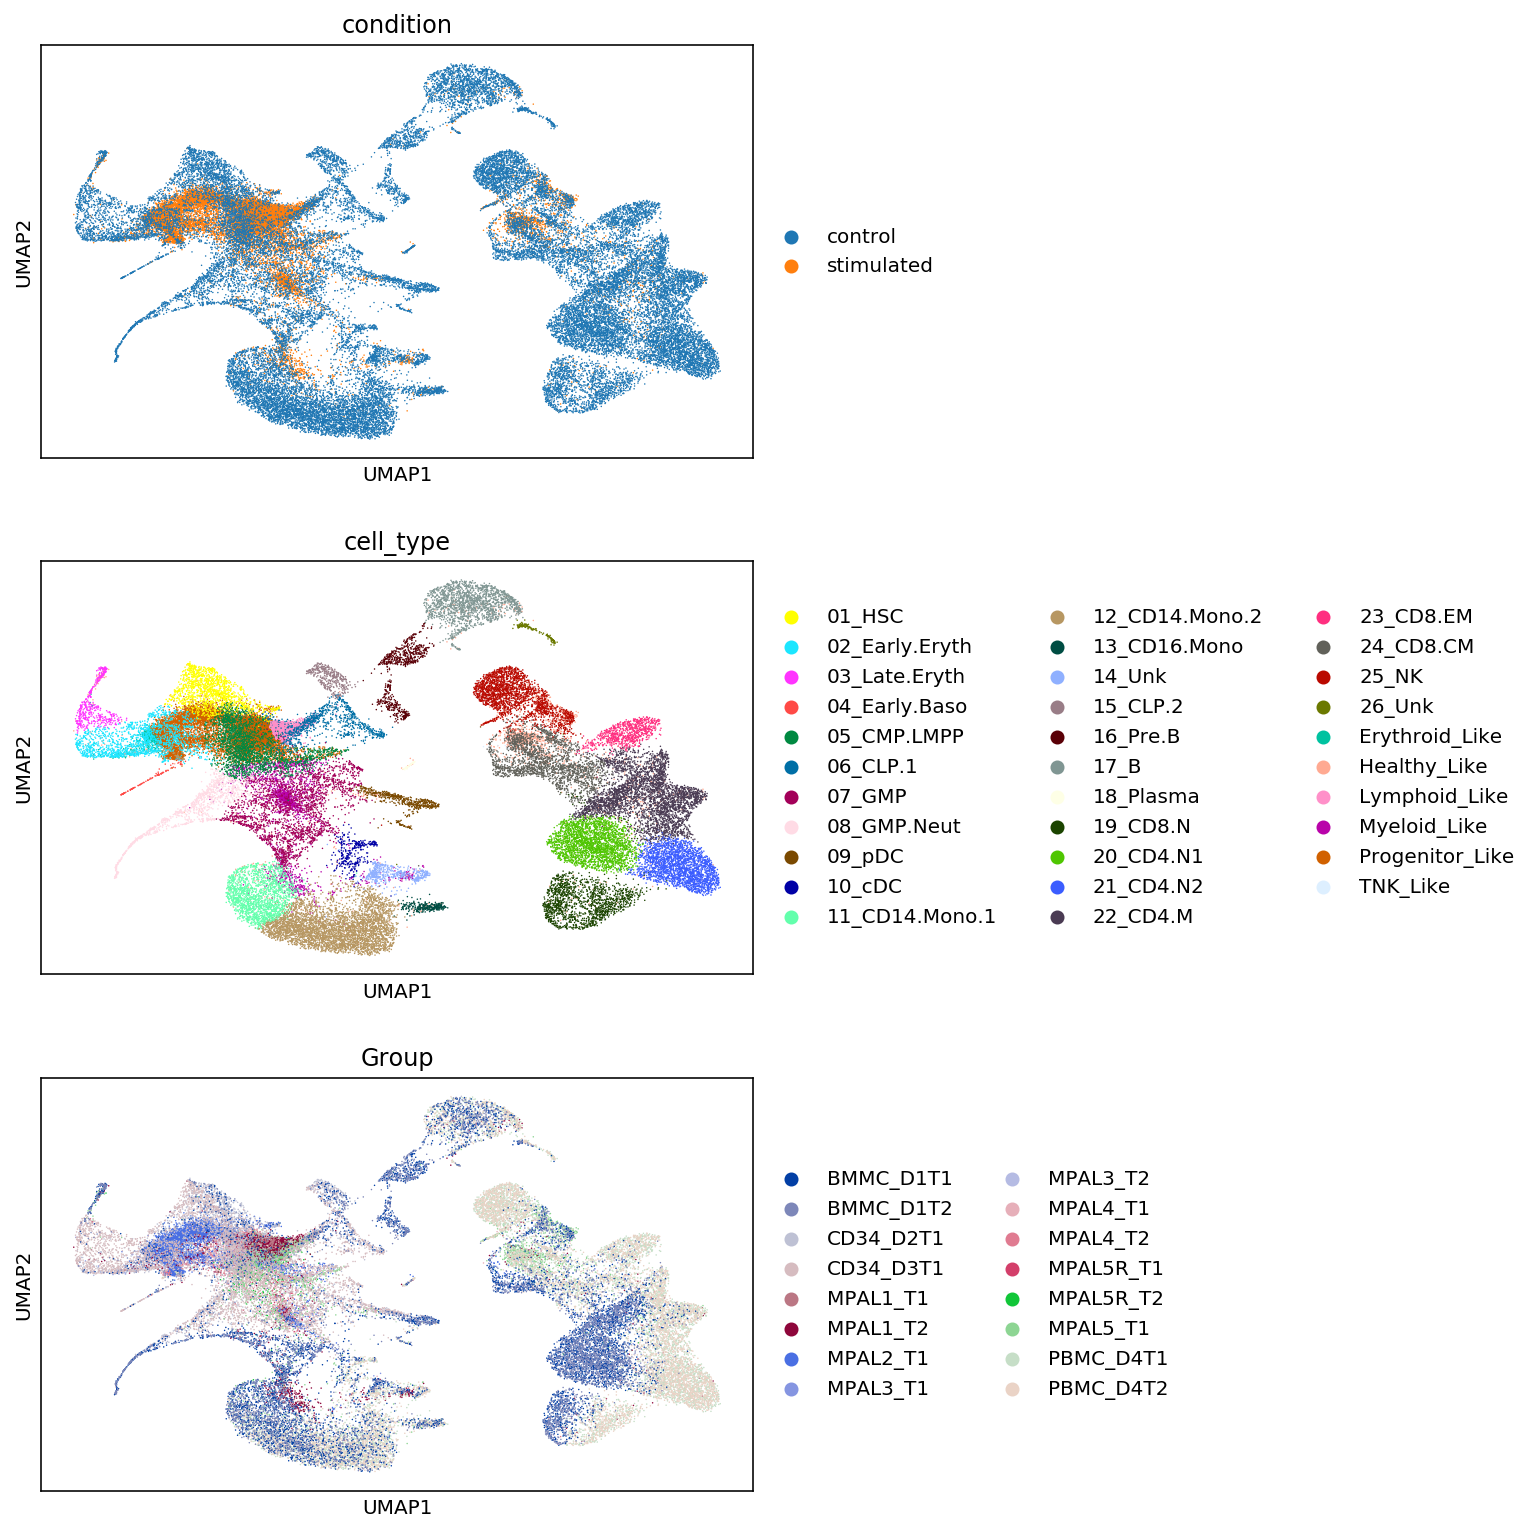

In [30]:
sc.pl.umap(scrna, color=['condition', 'cell_type', 'Group'], ncols=1)

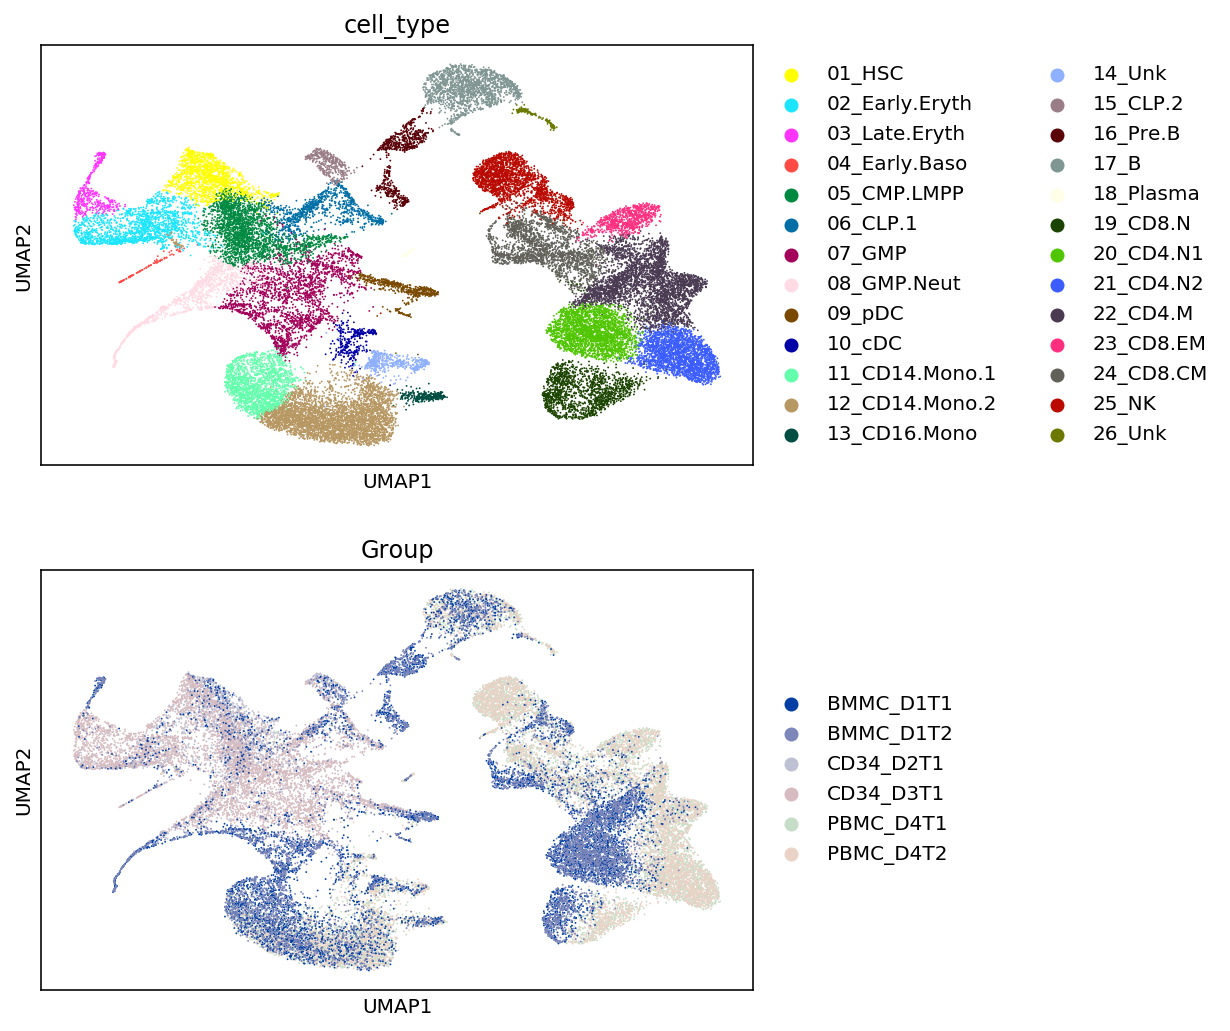

In [31]:
sc.pl.umap(scrna[scrna.obs['condition'] == 'control'], color=['cell_type', 'Group'], ncols=1)

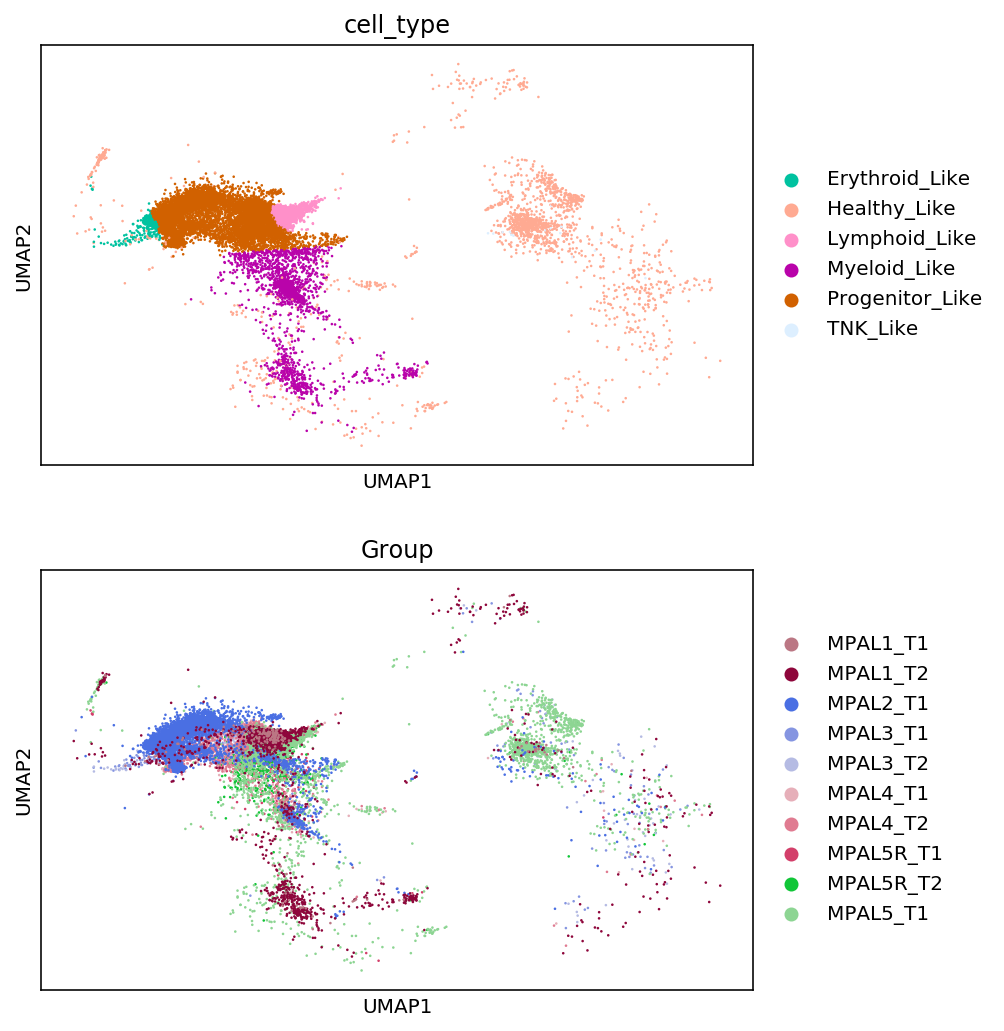

In [32]:
sc.pl.umap(scrna[scrna.obs['condition'] == 'stimulated'], color=['cell_type', 'Group'], ncols=1)

In [33]:
sc.pp.normalize_per_cell(scrna)
sc.pp.log1p(scrna)

In [34]:
scrna

AnnData object with n_obs × n_vars = 53638 × 20287 
    obs: 'Group', 'nUMI_pre', 'nUMI', 'nGene', 'cell_type', 'Barcode', 'condition', 'n_counts'
    var: 'gene_name', 'gene_id', 'exonLength'
    uns: 'condition_colors', 'cell_type_colors', 'Group_colors'
    obsm: 'X_umap'

In [35]:
%time scrna.write(SCRNA_DIR + 'expressions.h5ad')

CPU times: user 724 ms, sys: 752 ms, total: 1.48 s
Wall time: 4.51 s
